[View in Colaboratory](https://colab.research.google.com/github/HectorPulido/Python-And-Datascience-Test/blob/master/ConvolucionalDigitClasifier.ipynb)

In [0]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import time
import math
from datetime import timedelta
from sklearn.metrics import confusion_matrix

In [3]:
from  tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets('data/MNIST/', one_hot=True)

data.test.cls = np.argmax(data.test.labels, axis=1)

Extracting data/MNIST/train-images-idx3-ubyte.gz
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz


In [0]:
#Hyper parameters

# Convolutional Layer 1.
filter_size1 = 5          # Convolution filters are 5 x 5 pixels.
num_filters1 = 16         # There are 16 of these filters.

# Convolutional Layer 2.
filter_size2 = 5          # Convolution filters are 5 x 5 pixels.
num_filters2 = 36         # There are 36 of these filters.

# Fully-connected layer.
fc_size = 128             # Number of neurons in fully-connected layer.

# We know that MNIST images are 28 pixels in each dimension.
img_size = 28

# Images are stored in one-dimensional arrays of this length.
img_size_flat = img_size * img_size

# Tuple with height and width of images used to reshape arrays.
img_shape = (img_size, img_size)

# Number of colour channels for the images: 1 channel for gray-scale.
num_channels = 1

# Number of classes, one class for each of 10 digits.
num_classes = 10

train_batch_size = 64
learningRate = 1e-4

In [0]:
def plot_images(images, imgs_cls, predict_cls = None):
  assert len(images) == len(imgs_cls)
  
  s = len(images)
  
  fig, axes = plt.subplots(s/4, 4)
  fig.subplots_adjust(hspace = 0.5, wspace = 0.5)
  
  for i, ax in enumerate (axes.flat):
    ax.imshow(images[i].reshape(img_shape), cmap = 'binary')
    
    if predict_cls is None:
      xlabel = "Class: {0}".format(imgs_cls[i])
    else:
      t = imgs_cls[i] == predict_cls[i]
      xlabel = "Class: {0}, \nPrediction: {1}, \nThe predict was {2}".format(imgs_cls[i], predict_cls[i], t)
      
    ax.set_xlabel(xlabel)
    
    ax.set_xticks([])
    ax.set_yticks([])
  plt.show()

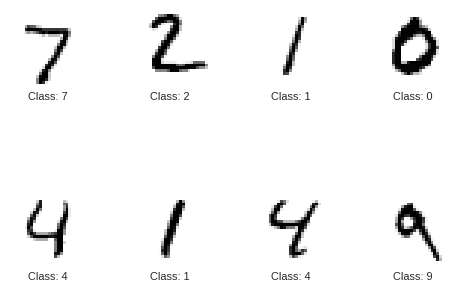

In [6]:
plot_images(images = data.test.images[0:9], imgs_cls = data.test.cls[0:9])

In [0]:
def new_weights(shape):
  return tf.Variable(tf.truncated_normal(shape, stddev = 0.05))

In [0]:
def new_biases(length):
  return tf.Variable(tf.constant(0.05, shape = [length] ))

In [0]:
def new_conv_layer(input, num_input_channels, filter_size, num_filters, use_pooling = True):
  shape = [filter_size, filter_size, num_input_channels, num_filters]
  weights = new_weights(shape = shape)
  biases = new_biases(length = num_filters)
  layer = tf.nn.conv2d(input = input, filter = weights, strides = [1,1,1,1], padding='SAME') 
  # CONVOLUCION
  #STRIDES da informacion sobre el movimiento del filtro
  layer += biases
  if use_pooling:
    layer = tf.nn.max_pool(value = layer, ksize = [1,2,2,1], strides = [1,2,2,1], padding = 'SAME')
    #POOLING
  layer = tf.nn.relu(layer)
  
  return layer, weights

In [0]:
def flatten_layer(layer):
  layer_shape = layer.get_shape()  
  num_features = layer_shape[1:4].num_elements()
  # layer_shape == [num_images, img_height, img_width, num_channels]
  # The number of features is: img_height * img_width * num_channels
  layer_flat = tf.reshape(layer, [-1, num_features])
  
  return layer_flat, num_features

In [0]:
def new_fc_layer(input, num_inputs, num_outputs, use_relu = True):
  weights = new_weights(shape=[num_inputs, num_outputs])
  biases = new_biases(length = num_outputs)
  
  layer = tf.matmul(input, weights) + biases
  
  if(use_relu):
    layer = tf.nn.relu(layer)
    
  return layer

In [0]:
#Tensors
x = tf.placeholder(tf.float32, shape = [None, img_size_flat], name = 'x')
x_image = tf.reshape(x, [-1, img_size, img_size, num_channels])
y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name = 'y_true')
y_true_cls = tf.argmax(y_true, axis=1)

In [0]:
#hierarchical model
layer_conv1, weights_conv1 = new_conv_layer(input = x_image, 
                                            num_input_channels = num_channels, 
                                            filter_size = filter_size1, 
                                            num_filters = num_filters1)

layer_conv2, weights_conv2 = new_conv_layer(input = layer_conv1, 
                                            num_input_channels = num_filters1, 
                                            filter_size = filter_size2, 
                                            num_filters = num_filters2)

layer_flat, num_features = flatten_layer(layer_conv2)

layer_fc1 = new_fc_layer(input=layer_flat,
                         num_inputs=num_features,
                         num_outputs=fc_size)

layer_fc2 = new_fc_layer(input=layer_fc1,
                         num_inputs=fc_size,
                         num_outputs=num_classes,
                         use_relu=False)
y_pred = tf.nn.softmax(layer_fc2)
y_pred_cls = tf.argmax(y_pred, axis = 1)

In [0]:
#Optimization
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits = layer_fc2, 
                                                        labels = y_true)
cost = tf.reduce_mean(cross_entropy)

optimizer = tf.train.AdamOptimizer(learning_rate = learningRate).minimize(cost)
correct_prediction = tf.equal(y_pred_cls , y_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [0]:
#Session start
session = tf.Session()
session.run(tf.global_variables_initializer())

In [0]:
total_iterations = 0

def optimize(num_iterations):
  global total_iterations
  
  start_time = time.time()
  
  for i in range (total_iterations, total_iterations + num_iterations):
    x_batch, y_true_batch = data.train.next_batch(train_batch_size)
    
    feed_dict_train = {x: x_batch, y_true: y_true_batch}
    
    session.run(optimizer, feed_dict = feed_dict_train)
    
    if i % 100 == 0:
      acc = session.run(accuracy, feed_dict = feed_dict_train)
      print "Optimization Iteration: {}, Training Accuracy: {}".format(i+1, acc)
      
  total_iterations += num_iterations;

  end_time = time.time()

  time_dif = end_time - start_time

  print "Time usage: " + str(timedelta(seconds = int(round(time_dif))))

In [0]:
def print_confusion_matrix(cls_pred): 
  real_class = data.test.cls
  cls_true = data.test.cls
  
  cm = confusion_matrix(y_true=cls_true,
                          y_pred=cls_pred)

  plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
  plt.tight_layout()
  plt.colorbar()
  tick_marks = np.arange(num_classes)
  plt.xticks(tick_marks, range(num_classes))
  plt.yticks(tick_marks, range(num_classes))
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.show()

In [0]:
def plot_example_errors (cls_pred, correct):
    incorrect = (correct == False)
    images = data.test.images[incorrect]
    cls_pred = cls_pred[incorrect]
    cls_true = data.test.cls[incorrect]

    plot_images(images = images[0:9], imgs_cls = cls_true[0:9], predict_cls = cls_pred[0:9])

In [0]:
test_batch_size = 256

def print_test_accuracy(show_example_errors=False,
                        show_confusion_matrix=False):

    num_test = len(data.test.images)

    cls_pred = np.zeros(shape=num_test, dtype=np.int)
    i = 0

    while i < num_test:
        j = min(i + test_batch_size, num_test)

        images = data.test.images[i:j, :]

        labels = data.test.labels[i:j, :]
        feed_dict = {x: images,
                     y_true: labels}

        cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)

        i = j

    cls_true = data.test.cls

    correct = (cls_true == cls_pred)

    correct_sum = correct.sum()

    acc = float(correct_sum) / num_test

    msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, correct_sum, num_test))
    
    if show_example_errors:
        print("Example errors:")
        plot_example_errors(cls_pred=cls_pred, correct=correct)

    if show_confusion_matrix:
        print("Confusion Matrix:")
        print_confusion_matrix(cls_pred=cls_pred)

Accuracy on Test-Set: 9.1% (914 / 10000)
Example errors:


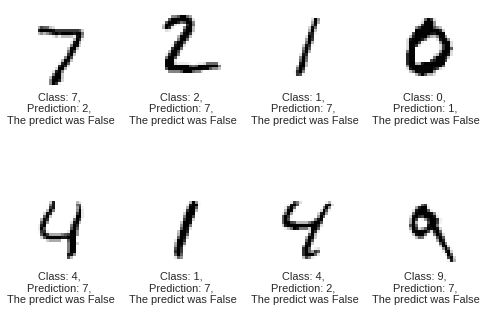

Confusion Matrix:


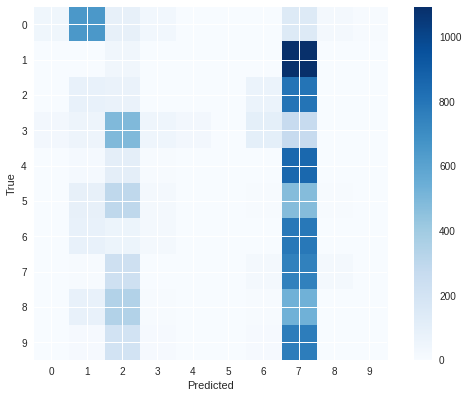

In [20]:
print_test_accuracy(True, True)

In [21]:
optimize(num_iterations=1)
print_test_accuracy()

Optimization Iteration: 1, Training Accuracy: 0.125
Time usage: 0:00:00
Accuracy on Test-Set: 10.9% (1094 / 10000)


In [22]:
optimize(num_iterations=99)
print_test_accuracy()

Time usage: 0:00:01
Accuracy on Test-Set: 61.5% (6154 / 10000)


In [23]:
optimize(num_iterations=900)
print_test_accuracy()

Optimization Iteration: 101, Training Accuracy: 0.53125
Optimization Iteration: 201, Training Accuracy: 0.828125
Optimization Iteration: 301, Training Accuracy: 0.875
Optimization Iteration: 401, Training Accuracy: 0.921875
Optimization Iteration: 501, Training Accuracy: 0.875
Optimization Iteration: 601, Training Accuracy: 0.90625
Optimization Iteration: 701, Training Accuracy: 0.84375
Optimization Iteration: 801, Training Accuracy: 0.921875
Optimization Iteration: 901, Training Accuracy: 0.859375
Time usage: 0:00:05
Accuracy on Test-Set: 93.8% (9380 / 10000)


Optimization Iteration: 1001, Training Accuracy: 0.9375
Optimization Iteration: 1101, Training Accuracy: 0.921875
Optimization Iteration: 1201, Training Accuracy: 0.90625
Optimization Iteration: 1301, Training Accuracy: 0.9375
Optimization Iteration: 1401, Training Accuracy: 0.953125
Optimization Iteration: 1501, Training Accuracy: 0.90625
Optimization Iteration: 1601, Training Accuracy: 0.921875
Optimization Iteration: 1701, Training Accuracy: 0.921875
Optimization Iteration: 1801, Training Accuracy: 0.953125
Optimization Iteration: 1901, Training Accuracy: 0.96875
Optimization Iteration: 2001, Training Accuracy: 0.984375
Optimization Iteration: 2101, Training Accuracy: 0.984375
Optimization Iteration: 2201, Training Accuracy: 1.0
Optimization Iteration: 2301, Training Accuracy: 0.921875
Optimization Iteration: 2401, Training Accuracy: 0.9375
Optimization Iteration: 2501, Training Accuracy: 0.96875
Optimization Iteration: 2601, Training Accuracy: 0.96875
Optimization Iteration: 2701, 

Optimization Iteration: 6801, Training Accuracy: 0.96875
Optimization Iteration: 6901, Training Accuracy: 0.984375
Optimization Iteration: 7001, Training Accuracy: 0.96875
Optimization Iteration: 7101, Training Accuracy: 0.984375
Optimization Iteration: 7201, Training Accuracy: 1.0
Optimization Iteration: 7301, Training Accuracy: 0.984375
Optimization Iteration: 7401, Training Accuracy: 1.0
Optimization Iteration: 7501, Training Accuracy: 0.96875
Optimization Iteration: 7601, Training Accuracy: 0.984375
Optimization Iteration: 7701, Training Accuracy: 0.96875
Optimization Iteration: 7801, Training Accuracy: 0.96875
Optimization Iteration: 7901, Training Accuracy: 0.96875
Optimization Iteration: 8001, Training Accuracy: 1.0
Optimization Iteration: 8101, Training Accuracy: 1.0
Optimization Iteration: 8201, Training Accuracy: 0.984375
Optimization Iteration: 8301, Training Accuracy: 1.0
Optimization Iteration: 8401, Training Accuracy: 1.0
Optimization Iteration: 8501, Training Accuracy: 0

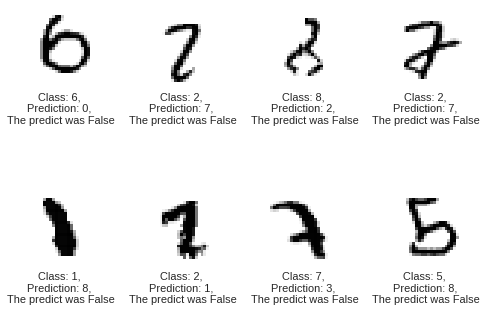

Confusion Matrix:


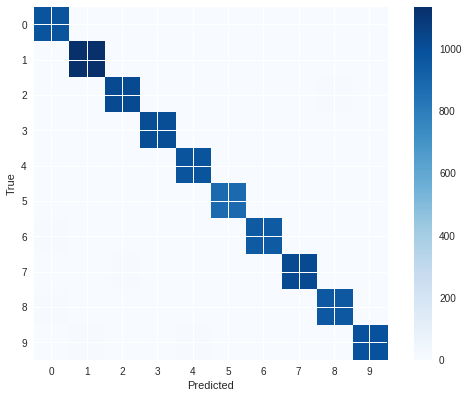

In [24]:
optimize(num_iterations=9900)
print_test_accuracy(True, True)